In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read and save data: never run again

In [2]:
falice = 'QKD_Lab_data/input-keys.alice'
fbob   = 'QKD_Lab_data/input-keys.bob'
fdecoy = 'QKD_Lab_data/input-keys.decoy'

encoding_big = {'0': 'H', '1': 'V', '2': 'D', '3': 'A'}
encoding_lit = {'0': 'H', '1': 'D', '2': 'V', '3': 'A'}
decoy_lit = {'0' : 'S', '2' : 'W'}

acq_time = 3600 # change here

def to_states(byte_input, encoding):
    num = int.from_bytes(byte_input, byteorder='big', signed=False)
    states = [(num & ii) >> jj for (ii,jj) in zip([192,48,12,3],[6,4,2,0])]
    states = [encoding[str(states[i])] for i in range(len(states))]
    states.reverse()
    return states

def decode(file, encoding, num=acq_time):
    with open(file, 'rb') as f:
        decoded = []
        count = 0
        while count < num:
            N = f.read(8)
            N = int.from_bytes(N, 'big')
            for _ in range(N):
                print(f'Processing block {count+1}/{num}')
                decoded += to_states(f.read(1), encoding)
            count += 1
    return decoded


def decode_N(file, encoding, block_sizes, num=acq_time):
    with open(file, 'rb') as f:
        decoded = []
        count = 0
        while count < num:
            N = f.read(8)
            N = int.from_bytes(N, 'big')
            block_sizes.append(N)
            for _ in range(N):
                print(f'Processing block {count+1}/{num}')
                decoded += to_states(f.read(1), encoding)
            count += 1
    return decoded

In [3]:
# print('Reading Alice ...')
# alice_states = decode(falice, encoding_lit)
# print('Reading Bob ...')
# bob_states   = decode(fbob, encoding_lit)

# block_sizes = []
# print('Reading decoy ...')
# decoy_states = decode_N(fdecoy, decoy_lit, block_sizes)

### Divide in chunks

In [4]:
size = 200

def divide(file, encoding, name, size = size):
    blocksizes = np.loadtxt('block_sizes.txt')
    chunksizes = [sum( blocksizes[i*size:(i+1)*size] ) for i in range(int(len(blocksizes)/size))]

    with open(file, 'rb') as f:
        for numchunk, chunk in enumerate(chunksizes):
            decoded = []
            count = 0
            while count < chunk:
                N = f.read(8)
                N = int.from_bytes(N, 'big')
                
                for _ in range(N):
                    decoded += to_states(f.read(1), encoding)
                    count += 1
            filename = 'results/{}_{}.csv'.format(name, numchunk)
            a = np.asarray([ decoded ])
            np.savetxt(filename, a, delimiter="\n", fmt="%s")


In [5]:
# SCOMMENTA QUA PER COSTRUIRE I FILES

# divide(falice, encoding_lit, 'alice')
# divide(fbob, encoding_lit, 'bob')
# divide(fdecoy, decoy_lit, 'decoy')

In [6]:
p_t_HV = .90
p_t_D  = .10

p_r_HV = .50
p_r_DA = .50

p_d_S  = .70
p_d_W  = .30

mu1 = 0.4699
mu2 = 0.1093

In [7]:
def count_Z(df):
    n_Z    = sum(df['B_basis_Z'])
    df_mZ  = df[(df['A_basis_Z']) & (df['B_basis_Z'])]
    m_Z    = len(df_mZ[df_mZ['A']!= df_mZ['B']])
    
    return n_Z, m_Z

def compute_QBER_Z(df):
    n_Z, m_Z = count_Z(df)
    QBER_Z = m_Z / n_Z

    return QBER_Z
    
def count_X(df):
    n_X    = len(df) - sum(df['B_basis_Z'])
    df_mX  = df[ ~ ((df['A_basis_Z']) | (df['B_basis_Z']))]
    m_X    = len(df_mX[df_mX['A'] != df_mX['B']])
    
    return n_X, m_X

def compute_QBER_X(df):
    n_X, m_X = count_X(df)
    QBER_X = m_X / n_X
                 
    return QBER_X

### Load and process files

In [8]:
blocksizes = np.loadtxt('block_sizes.txt')
n_points = int(len(blocksizes)/size)
chunksizes = [sum( blocksizes[i*size:(i+1)*size] ) for i in range(n_points)]

n_Z_list = np.array([5875048., 5714369., 5717431., 5744896., 5757869., 5780753.,
       5721273., 6286339., 7760382., 7822475., 7852461., 7882148.,
       7947703., 8100780., 8137429., 8054261., 8058419., 4774662.])

m_Z_list = np.array([ 92364.,  90972.,  93874.,  95823.,  97328., 105939., 114998.,
       128827., 152995., 164311., 174465., 177907., 179530., 182573.,
       186480., 188921., 188488., 113278.])
n_X_list = np.array([631531., 616261., 617663., 620534., 621702., 627146., 608931.,
       662056., 816654., 834749., 841172., 842758., 851083., 862799.,
       861733., 852588., 856007., 508573.])
m_X_list = np.array([ 7402.,  7049.,  6729.,  7180.,  7288.,  7060.,  6846.,  8050.,
        8768.,  8828.,  9533.,  9837.,  9522.,  9672., 10287., 10706.,
       10068.,  6140.])

n_Z_S_list = np.array([5340798., 5197333., 5199984., 5226004., 5238527., 5258420.,
       5205156., 5713980., 7048228., 7105884., 7142800., 7171606.,
       7232398., 7374698., 7406179., 7320651., 7321717., 4337901.])
m_Z_S_list = np.array([ 77380.,  76541.,  78836.,  80589.,  82035.,  89688.,  98001.,
       110630., 132094., 142214., 151426., 154526., 156199., 159199.,
       162577., 164686., 164061.,  98551.])
n_Z_W_list = np.array([534250., 517036., 517447., 518892., 519342., 522333., 516117.,
       572359., 712154., 716591., 709661., 710542., 715305., 726082.,
       731250., 733610., 736702., 436761.])
m_Z_W_list = np.array([14984., 14431., 15038., 15234., 15293., 16251., 16997., 18197.,
       20901., 22097., 23039., 23381., 23331., 23374., 23903., 24235.,
       24427., 14727.])
n_X_S_list = np.array([574453., 560713., 561947., 564325., 565749., 570604., 554287.,
       601444., 741997., 758576., 765329., 767087., 774468., 785090.,
       784120., 775325., 777817., 462340.])
m_X_S_list = np.array([6119., 5777., 5480., 5885., 5982., 5780., 5624., 6731., 7276.,
       7269., 7944., 8260., 7958., 8038., 8569., 8960., 8450., 5116.])
n_X_W_list = np.array([57078., 55548., 55716., 56209., 55953., 56542., 54644., 60612.,
       74657., 76173., 75843., 75671., 76615., 77709., 77613., 77263.,
       78190., 46233.])
m_X_W_list = np.array([1283., 1272., 1249., 1295., 1306., 1280., 1222., 1319., 1492.,
       1559., 1589., 1577., 1564., 1634., 1718., 1746., 1618., 1024.])

QBER_Z = np.array([0.0157214 , 0.01591987, 0.01641891, 0.01667968, 0.01690348,
       0.01832616, 0.02010007, 0.02049317, 0.01971488, 0.02100499,
       0.02221788, 0.02257088, 0.02258892, 0.02253771, 0.02291633,
       0.02345603, 0.0233902 , 0.02372482])
QBER_X = np.array([0.01172072, 0.01143834, 0.01089429, 0.01157068, 0.01172266,
       0.01125735, 0.01124265, 0.01215909, 0.01073649, 0.01057563,
       0.011333  , 0.01167239, 0.0111881 , 0.01121003, 0.01193757,
       0.01255706, 0.01176159, 0.012073  ])

chunksizes = n_Z_list + n_X_list

In [9]:
# blocksizes = np.loadtxt('block_sizes.txt')
# n_points = int(len(blocksizes)/size)
# chunksizes = [sum( blocksizes[i*size:(i+1)*size] ) for i in range(n_points)]

# n_Z_list = np.zeros(n_points)
# # m_Z_list = np.zeros(n_points)
# n_X_list = np.zeros(n_points)
# m_X_list = np.zeros(n_points)

# n_Z_S_list = np.zeros(n_points)
# m_Z_S_list = np.zeros(n_points)
# n_Z_W_list = np.zeros(n_points)
# m_Z_W_list = np.zeros(n_points)
# n_X_S_list = np.zeros(n_points)
# m_X_S_list = np.zeros(n_points)
# n_X_W_list = np.zeros(n_points)
# m_X_W_list = np.zeros(n_points)

# QBER_Z = np.zeros(n_points)
# QBER_X = np.zeros(n_points)

# for i in range(n_points):
#     print(f'Working on block #{i} ...')
    
#     alice = pd.read_csv('results/alice_{}.csv'.format(i), names=['A'], dtype=object)
#     bob = pd.read_csv('results/bob_{}.csv'.format(i), names=['B'], dtype=object)
#     decoy = pd.read_csv('results/decoy_{}.csv'.format(i), names=['D'], dtype=object)
#     df = pd.concat([alice, bob, decoy], axis=1)

#     df['A_basis_Z'] = (df['A']=='H') | (df['A']=='V')
#     df['B_basis_Z'] = (df['B']=='H') | (df['B']=='V')
#     df = df[df['A_basis_Z'] == df['B_basis_Z']]

#     # compute m_Z_k
#     n_Z_S_list[i], m_Z_S_list[i] = count_Z(df[df['D']=='S'])
#     n_Z_W_list[i], m_Z_W_list[i] = count_Z(df[df['D']=='W'])
#     # compute m_X_k
#     n_X_S_list[i], m_X_S_list[i] = count_X(df[df['D']=='S'])
#     n_X_W_list[i], m_X_W_list[i] = count_X(df[df['D']=='W'])

#     # compute n_Z, m_Z, QBER_Z
#     n_Z_list[i], m_Z_list[i] = count_Z(df)
#     QBER_Z[i] = compute_QBER_Z(df)
#     # compute n_X, m_X, QBER_X
#     n_X_list[i], m_X_list[i] = count_X(df)
#     QBER_X[i] = compute_QBER_X(df)

### Analysis

In [10]:
def delta(n,eps):
    return np.sqrt(n*np.log(1/eps)*0.5)

def tau(n):
    strong_term = (p_d_S * np.exp(-mu1) * mu1**n) / np.math.factorial(n)
    weak_term = (p_d_W * np.exp(-mu2) * mu2**n) / np.math.factorial(n)
    return strong_term + weak_term

def gamma(a,b,c,d):
    fact1 = ((c+d)*(1-b)*b) / (c*d*np.log(2))
    fact2 = ((c+d)*21**2) / ((c*d)*(1-b)*b*a**2)
    return np.sqrt(fact1 * np.log2(fact2))

In [11]:
eps_sec = 1e-9
eps_cor = 1e-15
eps1    = 1/19 * eps_sec # define once for all
eps2    = 1/19 * eps_sec

# A16 + A14
def esse_u_basis_0(n_Z, m_Z, m_Z_mu1, m_Z_mu2):
    suz01 = 2 * ( tau(0) * (np.exp(mu1)/p_d_S) * (m_Z_mu1 + delta(m_Z, eps2)) + delta(n_Z, eps1) )
    suz02 = 2 * ( tau(0) * (np.exp(mu2)/p_d_W) * (m_Z_mu2 + delta(m_Z, eps2)) + delta(n_Z, eps1) )
    suz03 = 2 * ( m_Z + delta(n_Z, eps1) )
    
    return min(suz01, suz02, suz03)

# A17
def esse_l_basis_1(n_Z_mu1, n_Z_mu2, n_Z, suz0):
    return (tau(1)*mu1)/(mu2*(mu1-mu2)) * ( (n_Z_mu2 - delta(n_Z, eps1))                     \
                                            - (mu2**2/mu1**2) * (n_Z_mu1 + delta(n_Z, eps1)) \
                                            - (mu1**2-mu2**2)/(mu1**2) * (suz0 / tau(0)) )

# A19
def esse_l_basis_0(n_Z, n_Z_mu1, n_Z_mu2):
    res = (tau(0)/(mu1 - mu2)) * (mu1*(n_Z_mu2 - delta(n_Z, eps1)) - mu2*(n_Z_mu1 + delta(n_Z, eps1)))
    return max(res, 0)

# A22
def vi_u_X_1(m_X, m_X_mu1, m_X_mu2):
    return (tau(1)/(mu1 - mu2)) * ((m_X_mu1 + delta(m_X, eps2)) - (m_X_mu2 - delta(m_X, eps2)))

# A23
def phi_u_Z(v_x, s_x, s_z):
    r = v_x / s_x
    return r + gamma(eps_sec, r, s_z, s_x)

def h_2(x):
    return - x * np.log2(x) - (1-x) * np.log2(1-x)

# EQ1 : SKL
def ell(s0, s1, phi, QBER_Z):
    f = 1.5 # from 1.3 to 1.8
    lambda_EC = f * h_2(QBER_Z)
    return s0 + s1*(1 - h_2(phi)) - lambda_EC - 6 * np.log2(19 / eps_sec) - np.log2(2 / eps_cor)

In [12]:
ell_list = []

for i in range(n_points):
    print(f'Working on block #{i} ...')
    
    # compute m_Z_k
    n_Z_S, m_Z_S = n_Z_S_list[i], m_Z_S_list[i]
    n_Z_W, m_Z_W = n_Z_W_list[i], m_Z_W_list[i]
    # compute m_X_k
    n_X_S, m_X_S = n_X_S_list[i], m_X_S_list[i]
    n_X_W, m_X_W = n_X_W_list[i], m_X_W_list[i]

    # compute n_Z, m_Z
    n_Z, m_Z = n_Z_list[i], m_Z_list[i]
    # compute n_X, m_X
    n_X, m_X = n_X_list[i], m_X_list[i]

    params_suz0 = {
    'n_Z': n_Z,
    'm_Z': m_Z,
    'm_Z_mu1' : m_Z_S,
    'm_Z_mu2' : m_Z_W,
    }
    
    params_sux0 = {
    'n_Z': n_X,
    'm_Z': m_X,
    'm_Z_mu1' : m_X_S,
    'm_Z_mu2' : m_X_W,
    }

    suz0 = esse_u_basis_0(**params_suz0)
    
    s_z = esse_l_basis_1(n_Z_S, n_Z_W, n_Z, suz0)
    s0 = esse_l_basis_0(n_Z, n_Z_S, n_Z_W)
    v_x = vi_u_X_1(m_X, m_X_S, m_X_W)

    sux0 = esse_u_basis_0(**params_sux0)
    s_x = esse_l_basis_1(n_X_S, n_X_W, n_X, sux0)

    phi = phi_u_Z(v_x, s_x, s_z)

    ell_list.append(ell(s0, s_z, phi, QBER_Z[i]))

Working on block #0 ...
Working on block #1 ...
Working on block #2 ...
Working on block #3 ...
Working on block #4 ...
Working on block #5 ...
Working on block #6 ...
Working on block #7 ...
Working on block #8 ...
Working on block #9 ...
Working on block #10 ...
Working on block #11 ...
Working on block #12 ...
Working on block #13 ...
Working on block #14 ...
Working on block #15 ...
Working on block #16 ...
Working on block #17 ...


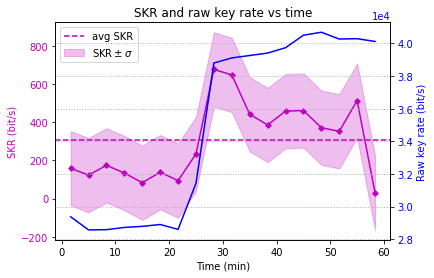

In [13]:
y = [e/size for e in ell_list]
y[-1] *= 200/119
y_2 = [nz/size for nz in n_Z_list]
y_2[-1] *= 200/119
x = np.array([i*200/60 for i in range(1,19)]) - 100/60

avg = np.mean(y)
std = np.std(y)
bc = [sum( blocksizes[i*size:(i+1)*size]/(size) ) for i in range(n_points)]

fig, ax1 = plt.subplots()

color = 'm'
ax1.set_xlabel('Time (min)')
ax1.plot(x, y, color=color, marker='D', markersize=4)
ax1.fill_between(x, y1=y+std, y2=y-std, alpha=0.25, color=color, label='$\mathrm{SKR}\pm\sigma$')
ax1.axhline(avg, color = 'm', linestyle = '--', label='avg SKR')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('SKR (bit/s)', color=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'b'
ax2.plot(x, y_2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Raw key rate (bit/s)', color=color)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#ax2.legend(loc='lower right')

plt.xlabel('Time (min)')
plt.title('SKR and raw key rate vs time')

plt.grid(linestyle=':', linewidth=1)
plt.savefig('non_cum_SKR.pdf')

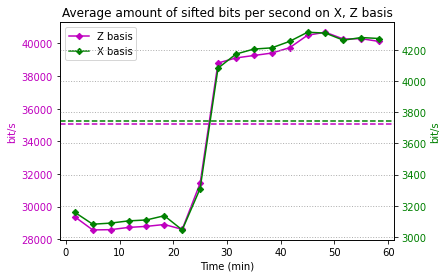

In [14]:
y = np.array(n_Z_list)/200
y[-1] *= 200/119
y_2 = np.array(n_X_list)/200
y_2[-1] *= 200/119
x = np.array([i*200/60 for i in range(1,19)]) - 100/60

avg1 = np.mean(y)
std1 = np.std(y)

avg2 = np.mean(y_2)
std2 = np.std(y_2)

fig, ax1 = plt.subplots()

color = 'm'
ax1.set_xlabel('Time (min)')
lns1 = ax1.plot(x, y, color=color, marker='D', markersize=4.5, label='Z basis')
#ax1.fill_between(x, y1=y+std1, y2=y-std1, alpha=0.25, color=color, label='$\mathrm{SKR}\pm\sigma$')
ax1.axhline(avg1, color = 'm', linestyle = '--', label='avg SKR')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('bit/s', color=color)


ax2 = ax1.twinx()
color = 'g'
ax2.set_xlabel('Time (min)')
lns2 = ax2.plot(x, y_2, color=color, marker='D', markersize=4.5, label='X basis')
#ax2.fill_between(x, y1=y_2+std2, y2=y_2-std2, alpha=0.25, color=color, label='$\mathrm{SKR}\pm\sigma$')
ax2.axhline(avg2, color = color, linestyle = '--', label='avg SKR')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('bit/s', color=color)
#ax2.legend(loc='upper left')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

plt.xlabel('Time (min)')
plt.title('Average amount of sifted bits per second on X, Z basis')

plt.grid(linestyle=':', linewidth=1)
plt.savefig('SiftedBitsPerSecond.pdf', bbox_inches='tight')

In [15]:
np.mean(y) / np.mean(y_2)

9.364809605816337

In [16]:
cum_ell_list = []

n_Z_S_cum = np.cumsum(n_Z_S_list)
m_Z_S_cum = np.cumsum(m_Z_S_list)
n_Z_W_cum = np.cumsum(n_Z_W_list)
m_Z_W_cum = np.cumsum(m_Z_W_list)
n_X_S_cum = np.cumsum(n_X_S_list)
m_X_S_cum = np.cumsum(m_X_S_list)
n_X_W_cum = np.cumsum(n_X_W_list)
m_X_W_cum = np.cumsum(m_X_W_list)
n_Z_cum = np.cumsum(n_Z_list)
m_Z_cum = np.cumsum(m_Z_list)
n_X_cum = np.cumsum(n_X_list)
m_X_cum = np.cumsum(m_X_list)
QBER_Z_cum = m_Z_cum / n_Z_cum

for i in range(len(ell_list)):

    # compute m_Z_k
    n_Z_S, m_Z_S = n_Z_S_cum[i], m_Z_S_cum[i]
    n_Z_W, m_Z_W = n_Z_W_cum[i], m_Z_W_cum[i]
    # compute m_X_k
    n_X_S, m_X_S = n_X_S_cum[i], m_X_S_cum[i]
    n_X_W, m_X_W = n_X_W_cum[i], m_X_W_cum[i]

    # compute n_Z, m_Z
    n_Z, m_Z = n_Z_cum[i], m_Z_cum[i]
    # compute n_X, m_X
    n_X, m_X = n_X_cum[i], m_X_cum[i]

    params_suz0 = {
    'n_Z': n_Z,
    'm_Z': m_Z,
    'm_Z_mu1' : m_Z_S,
    'm_Z_mu2' : m_Z_W,
    }
    
    params_sux0 = {
    'n_Z': n_X,
    'm_Z': m_X,
    'm_Z_mu1' : m_X_S,
    'm_Z_mu2' : m_X_W,
    }

    suz0 = esse_u_basis_0(**params_suz0)
    
    s_z = esse_l_basis_1(n_Z_S, n_Z_W, n_Z, suz0)
    s0 = esse_l_basis_0(n_Z, n_Z_S, n_Z_W)
    v_x = vi_u_X_1(m_X, m_X_S, m_X_W)

    sux0 = esse_u_basis_0(**params_sux0)
    s_x = esse_l_basis_1(n_X_S, n_X_W, n_X, sux0)

    phi = phi_u_Z(v_x, s_x, s_z)

    cum_ell_list.append(ell(s0, s_z, phi, QBER_Z_cum[i]))

In [17]:

filesizes = np.array([sum(blocksizes[i:i+200]) for i in range(len(blocksizes))])
filesizes


array([3219824., 3218457., 3217491., ...,       0.,       0.,       0.])

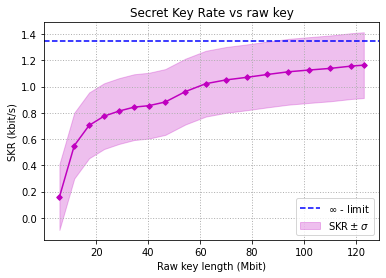

In [18]:
c_sizes = np.arange(len(chunksizes))
x = np.cumsum(n_Z_list) / 1e6
y = [e/(1e3*size*(c+1)) for e,c in zip(cum_ell_list,c_sizes)]
y[-1] *= 200*18/(200*17+119)

avg_asym = 1.3458169769951538
std = np.std(y)

plt.plot(x, y, color='m', marker = "D", markersize = 4)
plt.axhline(avg_asym, color = 'b', linestyle = '--', label='$\infty$ - limit')
plt.fill_between(x, y1=y+std, y2=y-std, alpha=0.25, color='m', label='$\mathrm{SKR}\pm\sigma$')

plt.title('Secret Key Rate vs raw key')
plt.xlabel('Raw key length (Mbit)')
plt.ylabel('SKR (kbit/s)')
plt.legend(loc='lower right')
plt.grid(linestyle=':', linewidth=1)
#plt.show()
plt.savefig('cumulative.pdf')

In [19]:
QBER_X_LIST = np.loadtxt('QBER_X_3519.dat')
QBER_Z_LIST = np.loadtxt('QBER_Z_3519.dat')

In [20]:
np.arange(n_points)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [21]:
# QBER_X_LIST = []
# QBER_Z_LIST = []

# break_all = False

# for i in np.arange(n_points):
#     print(f'Processing file #{i} ...')
#     alice = pd.read_csv('results/alice_{}.csv'.format(i), names=['A'], dtype=object)
#     bob = pd.read_csv('results/bob_{}.csv'.format(i), names=['B'], dtype=object)
#     decoy = pd.read_csv('results/decoy_{}.csv'.format(i), names=['D'], dtype=object)
#     df = pd.concat([alice, bob, decoy], axis=1)

#     df['A_basis_Z'] = (df['A']=='H') | (df['A']=='V')
#     df['B_basis_Z'] = (df['B']=='H') | (df['B']=='V')

#     QBER_Z = np.zeros(size)
#     QBER_X = np.zeros(size)

#     initial = 0
#     final = blocksizes[i*size]
    
    
#     for j,block in enumerate(blocksizes[ ((size*i)+1) : (size*(i+1)) ]):
#         df_sliced = df.iloc[int(initial):int(final)]
#         df_sliced = df_sliced[df_sliced['A_basis_Z'] == df_sliced['B_basis_Z']]
#         if len(df_sliced) < 1:
#             break_all = True
#             break

#         QBER_Z[j] = compute_QBER_Z(df_sliced)
#         QBER_X[j] = compute_QBER_X(df_sliced)

#         initial = final
#         final += block

#     if break_all: 
#         QBER_X_LIST += list(QBER_X)
#         QBER_Z_LIST += list(QBER_Z)
#         break
    
#     else: 
#         df_sliced = df.iloc[int(initial):int(final)]
#         df_sliced = df_sliced[df_sliced['A_basis_Z'] == df_sliced['B_basis_Z']]
#         QBER_Z[199] = compute_QBER_Z(df_sliced)
#         QBER_X[199] = compute_QBER_X(df_sliced)

#         QBER_X_LIST += list(QBER_X)
#         QBER_Z_LIST += list(QBER_Z)
    

In [22]:
# np.savetxt('QBER_X_3519.dat',QBER_X_LIST)
# np.savetxt('QBER_Z_3519.dat',QBER_Z_LIST)

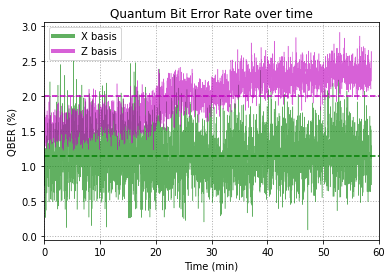

In [23]:
QBER_X_LIST = np.array(QBER_X_LIST[QBER_X_LIST>0])
QBER_Z_LIST = np.array(QBER_Z_LIST[QBER_Z_LIST>0])

x = np.array([i/60 for i in range(len(QBER_X_LIST))])
plt.plot(x,100*QBER_X_LIST, label='X basis', color='g', linewidth=0.5, alpha = 0.62)
plt.axhline(100*np.mean(QBER_X_LIST), color = 'g', linestyle = '--')
plt.plot(x,100*QBER_Z_LIST, label='Z basis', color='m', linewidth=0.5, alpha = 0.62)
plt.axhline(100*np.mean(QBER_Z_LIST), color = 'm', linestyle = '--')
plt.xlabel('Time (min)')
plt.ylabel('QBER (%)')
plt.xlim([0,60])
plt.title('Quantum Bit Error Rate over time')
leg = plt.legend(loc='upper left')
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.grid(linestyle=':', linewidth=1)
plt.savefig('QBER.pdf')

In [24]:
len(QBER_X_LIST[QBER_X_LIST>0])

3519

In [25]:
np.mean(QBER_Z_LIST[-20:])*100

2.2687981730763545

In [26]:
np.mean(QBER_Z_LIST[-20:])*100

2.2687981730763545

In [27]:
np.mean(QBER_Z_LIST[-40:-20])*100

2.354844945529332

In [28]:
np.mean(QBER_X_LIST[-40:-20])*100

1.0225474383503863